In [11]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import warnings
import sys
from transformers import AutoModelForSequenceClassification, AutoTokenizer


pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

model_name = "roberta-large-mnli"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
for name, param in model.named_parameters():
    print(name, param.size())

roberta.embeddings.word_embeddings.weight torch.Size([50265, 1024])
roberta.embeddings.position_embeddings.weight torch.Size([514, 1024])
roberta.embeddings.token_type_embeddings.weight torch.Size([1, 1024])
roberta.embeddings.LayerNorm.weight torch.Size([1024])
roberta.embeddings.LayerNorm.bias torch.Size([1024])
roberta.encoder.layer.0.attention.self.query.weight torch.Size([1024, 1024])
roberta.encoder.layer.0.attention.self.query.bias torch.Size([1024])
roberta.encoder.layer.0.attention.self.key.weight torch.Size([1024, 1024])
roberta.encoder.layer.0.attention.self.key.bias torch.Size([1024])
roberta.encoder.layer.0.attention.self.value.weight torch.Size([1024, 1024])
roberta.encoder.layer.0.attention.self.value.bias torch.Size([1024])
roberta.encoder.layer.0.attention.output.dense.weight torch.Size([1024, 1024])
roberta.encoder.layer.0.attention.output.dense.bias torch.Size([1024])
roberta.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([1024])
roberta.encoder.layer.0

In [ ]:
from transformers import pipeline
import torch
from datasets import load_dataset

ds = load_dataset("wangrongsheng/ag_news")

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Using device: cuda


In [24]:
print(ds["test"])
classifier = pipeline('zero-shot-classification', model='roberta-large-mnli', device=0)                              
sequence_to_classify = "badhiyab hai badhiya"
candidate_labels = ['travel', 'cooking', 'dancing', 'cricket', 'sports person', 'footballer', 'soccer player', 'actor']
classifier(sequence_to_classify, candidate_labels)


Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'sequence': 'badhiyab hai badhiya',
 'labels': ['cooking',
  'dancing',
  'travel',
  'sports person',
  'actor',
  'footballer',
  'soccer player',
  'cricket'],
 'scores': [0.22317245602607727,
  0.1654755026102066,
  0.16185957193374634,
  0.13351182639598846,
  0.10129747539758682,
  0.07446759939193726,
  0.07138204574584961,
  0.06883354485034943]}

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

def perform_error_analysis(dataset, classifier, num_samples=100):
    """
    Perform comprehensive error analysis on the zero-shot classifier.
    
    Args:
        dataset: The AG News dataset
        classifier: The zero-shot classification pipeline
        num_samples: Number of samples to analyze (use smaller number for testing)
    """
    # AG News labels mapping
    label_map = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }
    
    # Prepare candidate labels for zero-shot classification
    candidate_labels = list(label_map.values())
    
    # Store results
    results = []
    
    # Process test samples
    for i, item in tqdm(enumerate(dataset['test']), total=num_samples):
        if i >= num_samples:
            break
            
        text = item['text']
        true_label = label_map[item['label']]
        
        # Get model prediction
        prediction = classifier(text, candidate_labels)
        predicted_label = prediction['labels'][0]
        confidence = prediction['scores'][0]
        
        results.append({
            'text': text,
            'true_label': true_label,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'correct': true_label == predicted_label
        })
    
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    accuracy = (df_results['correct'].sum() / len(df_results)) * 100
    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    
    # 2. Per-class Performance
    print("\nPer-class Performance:")
    print(classification_report(df_results['true_label'], df_results['predicted_label']))
    
    # 3. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(df_results['true_label'], df_results['predicted_label'], labels=candidate_labels)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=candidate_labels, yticklabels=candidate_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 4. Confidence Analysis
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='true_label', y='confidence', hue='correct', data=df_results)
    plt.title('Confidence Distribution by Class and Correctness')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 5. Error Examples Analysis
    print("\nMost Confident Mistakes:")
    mistakes = df_results[~df_results['correct']].sort_values('confidence', ascending=False)
    print(mistakes[['text', 'true_label', 'predicted_label', 'confidence']].head())
    
    # 6. Length Analysis
    df_results['text_length'] = df_results['text'].str.len()
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='true_label', y='text_length', hue='correct', data=df_results)
    plt.title('Text Length Distribution by Class and Correctness')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df_results

In [33]:
def analyze_error_patterns(df_results):
    """
    Analyze specific patterns in the errors.
    """
    # Common misclassification patterns
    error_patterns = defaultdict(int)
    for _, row in df_results[~df_results['correct']].iterrows():
        pattern = f"{row['true_label']} → {row['predicted_label']}"
        error_patterns[pattern] += 1
    
    print("\nCommon Error Patterns:")
    for pattern, count in sorted(error_patterns.items(), key=lambda x: x[1], reverse=True):
        print(f"{pattern}: {count}")
        
    # Confidence threshold analysis
    thresholds = np.arange(0.1, 1.0, 0.1)
    accuracies = []
    coverage = []
    
    for threshold in thresholds:
        filtered_preds = df_results[df_results['confidence'] >= threshold]
        if len(filtered_preds) > 0:
            acc = (filtered_preds['correct'].sum() / len(filtered_preds)) * 100
            cov = (len(filtered_preds) / len(df_results)) * 100
            accuracies.append(acc)
            coverage.append(cov)
    
    # Ensure arrays are the same length before plotting
    min_len = min(len(accuracies), len(coverage))
    thresholds = thresholds[:min_len]
    accuracies = accuracies[:min_len]
    coverage = coverage[:min_len]
    
    if min_len > 0:  # Only plot if we have data
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, accuracies, 'b-', label='Accuracy')
        plt.plot(thresholds, coverage, 'r-', label='Coverage')
        plt.xlabel('Confidence Threshold')
        plt.ylabel('Percentage')
        plt.title('Accuracy vs Coverage Trade-off')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Warning: Not enough data points to create accuracy-coverage plot")


  0%|          | 0/5000 [00:00<?, ?it/s]


Overall Accuracy: 45.20%

Per-class Performance:
              precision    recall  f1-score   support

    Business       0.51      0.15      0.23      1204
    Sci/Tech       0.84      0.18      0.30      1240
      Sports       0.76      0.56      0.64      1270
       World       0.33      0.89      0.49      1286

    accuracy                           0.45      5000
   macro avg       0.61      0.45      0.41      5000
weighted avg       0.61      0.45      0.42      5000



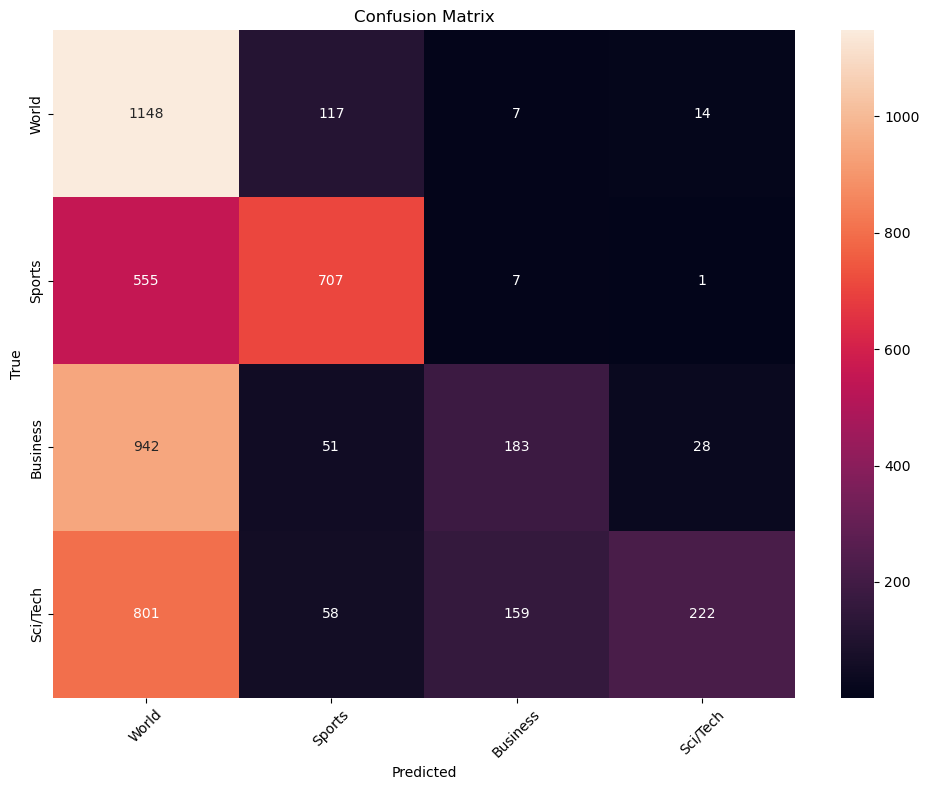

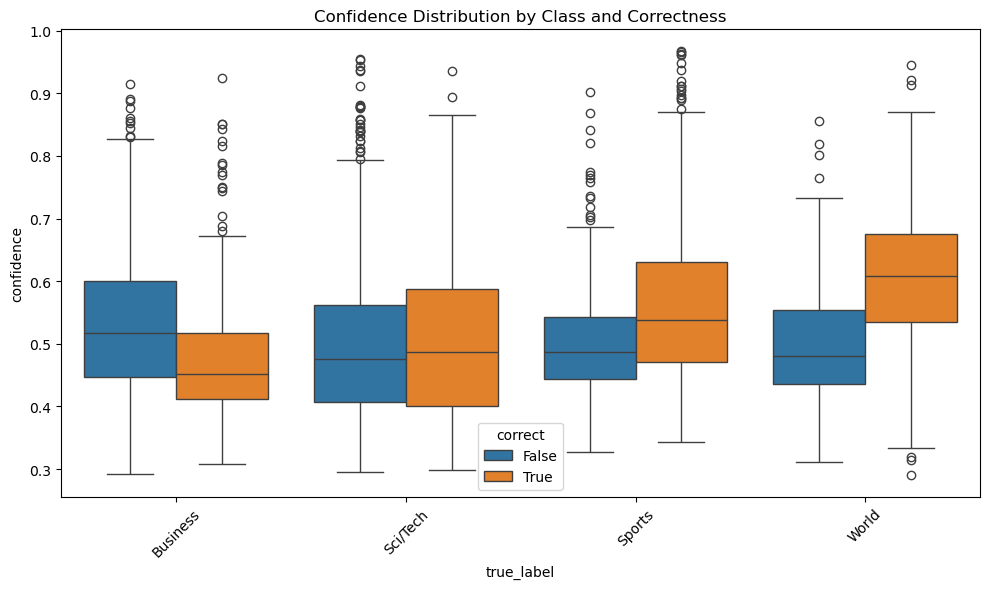


Most Confident Mistakes:
                                                                                                                                                                                                                                                                                                     text  \
4831                                                                               Dems, GOP: Who's Got the Brains? Well, both do, actually. But there are some discernible differences in brain activity which may just explain why a Democrat sees the world one way, and a Republican sees it another.   
702                                                                                                                                   HP Unveils Cavalcade of Consumer Products (PC World) PC World - First TVs, new printers, long-lasting inks, and projectors are targeted\ at living room and office.   
2379                                    BLOG That #39;s the most look-e

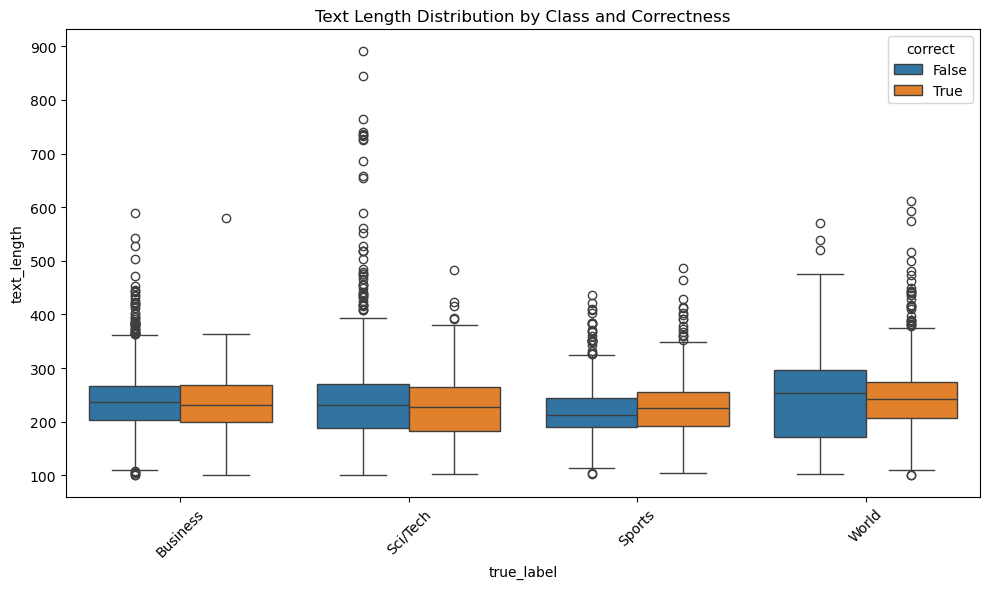


Common Error Patterns:
Business → World: 942
Sci/Tech → World: 801
Sports → World: 555
Sci/Tech → Business: 159
World → Sports: 117
Sci/Tech → Sports: 58
Business → Sports: 51
Business → Sci/Tech: 28
World → Sci/Tech: 14
Sports → Business: 7
World → Business: 7
Sports → Sci/Tech: 1


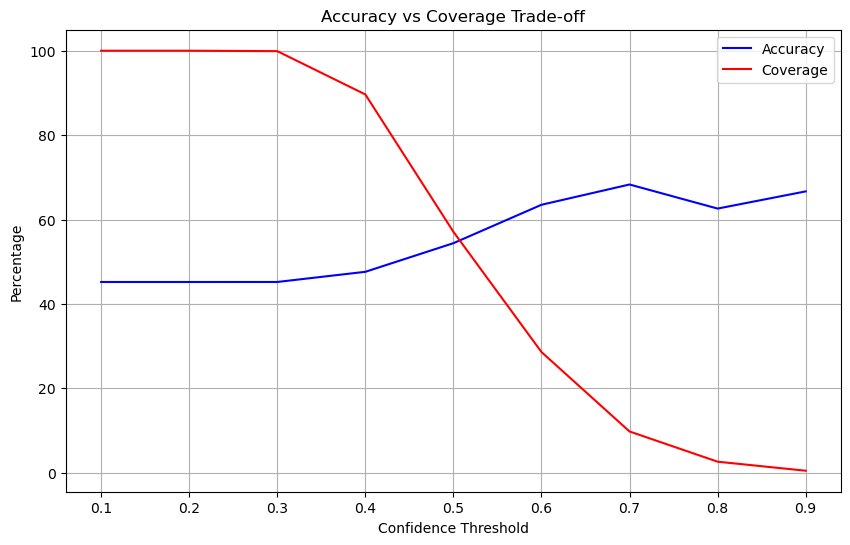

In [35]:
# Example usage
if __name__ == "__main__":
    # Perform main error analysis
    results_df = perform_error_analysis(ds, classifier, num_samples=5000)
    
    # Analyze error patterns
    analyze_error_patterns(results_df)